# Projet d'optimisation

In [41]:
import numpy as np
from scipy import optimize
from casadi import *
import time
import matplotlib.pyplot as plt

# Question 1

Le but du problème est de trouver l'allocation globale $x \in \mathbb{R}^m$ qui minimise le risque associé au rendement du portefeuille, i.e. la variance de cette allocation par rapport à la variation du prix des actifs $p \in \mathbb{R}^m$.

La variance est l'équivalent d'un "écart à la moyenne" ; elle représente donc bien un indicateur du risque associé à un investissement. Ce risque prend en compte le lien entre la variation des prix et les allocations, d'où $x^T \Sigma x$, où $\Sigma$ est la matrice de covariance associé à $p$.

La relation $\bold{1}^T x = 1$ signifie simplement que l'on normalise l'allocation par souci de cohérence et de clarté ; pour une allocation donnée, le rendement représente le gain moyen associé à l'allocation, d'où $\bar p^T x = r$.

# Question 2

On souhaite minimiser le risque, donc on a
$$
\begin{array}{rcl}
f : z & \longmapsto & f(z) = x^T \Sigma x
\end{array}
$$

La variable $z$ dépend donc de $x$, mais aussi de $\Sigma = \left[ \mathrm{Cov}(p_i, p_j) \right]_{i,j \in \llbracket 1, m \rrbracket}$ et donc de $p$. Le nombre de variables de décisions est  $n = 2$ ($p$ et $x$), où chaque variable est un vecteur de $\mathbb{R}^m$.

L'énoncé contraint le problème par le biais des conditions de normalisation $\bold{1}^T x = 1$ et de rendement $r = \bar p^T x$, on peut donc définir :
$$c_{eq}(z) = \begin{bmatrix} \bold{1}^T x - 1 \\ \overline{p}^T x - r \end{bmatrix} = \underbrace{\begin{bmatrix} \bold{1}^T \\ \overline{p}^T \end{bmatrix}}_{\in \mathbb{R}^{2 \times m}} \cdot \underbrace{x}_{\in \mathbb{R}^m} - \underbrace{\begin{bmatrix} 1 \\ r \end{bmatrix}}_{\in \mathbb{R}^2}$$
ce qui ajoute la contrainte égalité $$c_{eq}(z)  = 0$$ au problème de minimisation de $f$.

# Question 3

On ajoute une contrainte inégalité pour limiter les positions _short_ à un certain montant par allocation, afin de garantir un équilibre de marché, ne pas entraîner de trop fortes fluctuation des actifs et donc une variance trop élevée.

On a donc dans ce problème une contrainte égalité (représentée par la fonction $c_{eq}$) et une contrainte inégalité.

Or la contrainte inégalité comprend déjà une fonction $\max$ ; on cherche donc à minimiser une fonction $f$ sous contrainte d'une limitation d'un maximum, ce qui risque de compliquer les calculs... La fonction $\max$ est en effet non linéaire et non différentiable lorsque $x_i = 0$.

# Question 4

$\max(-x,\bold{0})$ vérifie
$\forall x \in \mathbb{R}^m, \max(-x,\bold{0}) ≥ -x$ et $\max(-x,\bold{0}) ≥ 0$.

En introduisant $s \in \mathbb{R}^m$ tel que $s ≥ -x$, $s ≥ 0$ et $\bold{1}^T s ≤ s_M$, on a 
$$\bold{1}^T \max(-x,\bold{0}) ≤ \bold{1}^T s ≤ s_M$$
En prenant $s$ le plus proche possible de $\max(-x,\bold{0})$, on peut reformuler de manière équivalente le problème de la question 2 :
$$\min f(z)$$
sous les contraintes $$\begin{cases} c_{eq}(z) = 0 \\ c_{ineq}(z) = \begin{bmatrix} -s - x \\ -s \\ \bold 1^{\top}s - s_M \end{bmatrix} ≤ 0 \end{cases}$$ 

Les 3 coordonnées de $c_{ineq}$ reprennent les 3 contraintes sur s.

De plus, la variable $s$ est indirectement liée à $x$, et donc à $z$, puisqu'elle est choisie en fonction de $-x$ (on veut avoir $s = \max(-x, \bold{0})$ en se débarrassant du max).

# Question 5

Le problème $(4)$ est un problème d'optimisation sous contrainte avec des contraintes égalité linéaires (donc convexes). La fonction $f$ à minimiser est quadratique et convexe car $\Sigma$ est semi-définie positive.

On peut donc penser dans un premier temps à la résolution d'un problème équivalent sans contraintes, en commençant par un algorithme d'élimination des contraintes appliqué à $c_{eq}$. Comme $f$ est 2 fois différentiable, on peut alors utiliser un algorithme utilisant une méthode de Newton, ou de quasi-Newton, comme BFGS par exemple.

Une autre méthode de résolution est d'utiliser les multiplicateurs de Lagrange, en calculant le lagrangien
$$\mathcal{L}(z, \lambda) = f(z) + \lambda^T c_{eq}(z)$$
puis en résolvant le problème dual (recherche de point de selle du lagrangien), avec un algorithme d'Uzawa ou d'Arrow-Hurwitz.

Dans la même veine, on peut tenter de résoudre analytiquement le problème avec les conditions $(KKT)$ : comme les contraintes sont affines, elles sont convexes, et la fonction $f$ l'est aussi donc on a une équivalence entre respecter les conditions $(KKT)$ et être solution du problème d'optimisation.

# Question 6

Pour résoudre numériquement le problème, on va utiliser les bibliothèques Scipy (avec son module _optimize_ et son solveur SLSQP) et Casadi (avec _ipopt_).

In [42]:
# Définition des variables
p1 = 0.05
p2 = 0.15
p3 = 0.3
p = np.array([p1, p2, p3])
rho = 0.1
r = 0.1

sig1 = 0.1
sig2 = 0.3
sig3 = 0.8
sigma = np.array([[sig1**2, rho*sig1*sig2, 0], [rho*sig1*sig2, sig2**2, 0], [0, 0, sig3**2]])

unit = np.ones(3)
x0 = np.array([0., 0., 0.]) #pour remplir la condition de normalisation

In [43]:
# Définition de la fonction variance et des contraintes

def var(x):
    return x.T @ sigma @ x

contraintes = ({'type': 'eq', 'fun': lambda x:  unit.T@x -1},
        {'type': 'eq', 'fun': lambda x: p.T@x - r})

In [44]:
# BFGS avec Scipy
print('méthode SLSQP avec Scipy (r = 0.1)')
start_time = time.time()
res = optimize.minimize(var, x0, method='SLSQP', jac=None, constraints=contraintes, options={'disp': True})
print("Allocation :", res.x)
print("Durée : ", time.time()-start_time)

méthode SLSQP avec Scipy (r = 0.1)
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.01706777545785351
            Iterations: 4
            Function evaluations: 16
            Gradient evaluations: 4
Allocation : [0.63284823 0.27858628 0.08856549]
Durée :  0.013119935989379883


In [45]:
# Résolution avec Casadi
opti_cons = casadi.Opti();
x = opti_cons.variable(3)

opti_cons.minimize(var(x))
opti_cons.subject_to(dot(unit.T, x) - 1 == 0)
opti_cons.subject_to(dot(p.T, x) - r == 0)

opti_cons.set_initial(x,x0)
opti_cons.solver('ipopt')

print("Résolution avec Casadi...")
start_time = time.time()
sol = opti_cons.solve()
print("Durée : ", time.time()-start_time)
print(sol.value(x))

Résolution avec Casadi...
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        6
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        6

Total number of variables............................:        3
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        2
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.00e+00 0.00e+00  -1.0 0.00e+0

On remarque que le temps de calcul avec Scipy et Casadi sont sensiblement les mêmes (de l'ordre de $10^{-3}$ s).

De plus, les 2 méthodes aboutissent au même résultat, à savoir une variance (et donc un risque associé) de l'ordre de $10^{-2}$.

# Question 7

$(a)$

$\rho$ est le coefficient de corrélation associé aux vecteurs $p_1$ et $p_2$ : c'est la corrélation entre les actifs. Il prend des valeurs dans l'intervalle $[-1, 1]$.

$(b)$

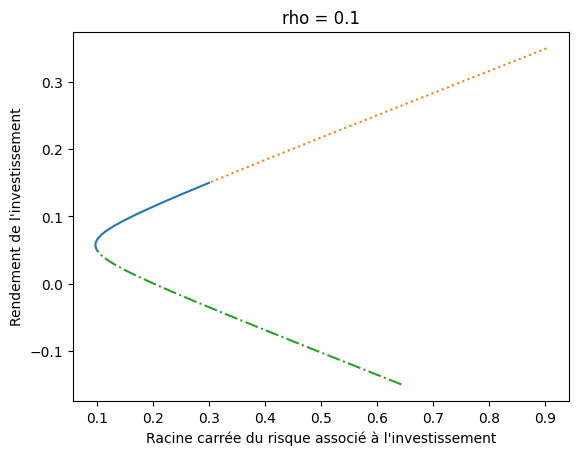

In [46]:
rho = 0.1
sigma = np.array([[sig1**2, rho*sig1*sig2, 0], [rho*sig1*sig2, sig2**2, 0], [0, 0, sig3**2]])

X1_1 = np.empty(1000)
Y1_1 = np.empty(1000)
for i in range(1000):
    x_1 = i/1000
    x_2 = 1 - x_1
    x_3 = 0
    x = np.array([x_1, x_2, x_3])
    X1_1[i] = np.sqrt(np.dot(np.dot(x,sigma),x))
    Y1_1[i] = np.dot(p,x)
    
X1_2 = np.empty(2000)
Y1_2 = np.empty(2000)
for i in range(-2000,0):
    x_1 = i/1000
    x_2 = 1 - x_1
    x_3 = 0
    x = np.array([x_1, x_2, x_3])
    X1_2[i] = np.sqrt(np.dot(np.dot(x,sigma),x))
    Y1_2[i] = np.dot(p,x)

X1_3 = np.empty(2000)
Y1_3 = np.empty(2000)
for i in range(-2000,0):
    x_2 = i/1000
    x_1 = 1 - x_2
    x_3 = 0
    x = np.array([x_1, x_2, x_3])
    X1_3[i] = np.sqrt(np.dot(np.dot(x,sigma),x))
    Y1_3[i] = np.dot(p,x)

plt.plot(X1_1, Y1_1, '-', label = '')
plt.plot(X1_2, Y1_2, ':', label = '')
plt.plot(X1_3, Y1_3, '-.', label = '')
plt.xlabel("Racine carrée du risque associé à l'investissement")
plt.ylabel("Rendement de l'investissement")
plt.title('rho = 0.1')
plt.show()

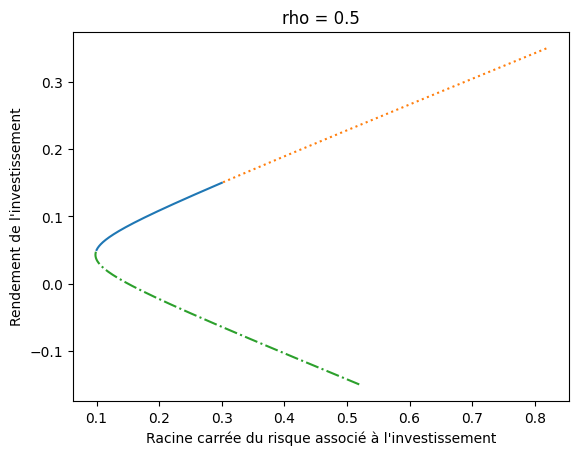

In [47]:
rho = 0.5
sigma = np.array([[sig1**2, rho*sig1*sig2, 0], [rho*sig1*sig2, sig2**2, 0], [0, 0, sig3**2]])

X2_1 = np.empty(1000)
Y2_1 = np.empty(1000)
for i in range(1000):
    x_1 = i/1000
    x_2 = 1 - x_1
    x_3 = 0
    x = np.array([x_1, x_2, x_3])
    X2_1[i] = np.sqrt(np.dot(np.dot(x,sigma),x))
    Y2_1[i] = np.dot(p,x)
    
X2_2 = np.empty(2000)
Y2_2 = np.empty(2000)
for i in range(-2000,0):
    x_1 = i/1000
    x_2 = 1 - x_1
    x_3 = 0
    x = np.array([x_1, x_2, x_3])
    X2_2[i] = np.sqrt(np.dot(np.dot(x,sigma),x))
    Y2_2[i] = np.dot(p,x)

X2_3 = np.empty(2000)
Y2_3 = np.empty(2000)
for i in range(-2000,0):
    x_2 = i/1000
    x_1 = 1 - x_2
    x_3 = 0
    x = np.array([x_1, x_2, x_3])
    X2_3[i] = np.sqrt(np.dot(np.dot(x,sigma),x))
    Y2_3[i] = np.dot(p,x)

plt.plot(X2_1, Y2_1, '-', label = '')
plt.plot(X2_2, Y2_2, ':', label = '')
plt.plot(X2_3, Y2_3, '-.', label = '')
plt.xlabel("Racine carrée du risque associé à l'investissement")
plt.ylabel("Rendement de l'investissement")
plt.title('rho = 0.5')
plt.show()

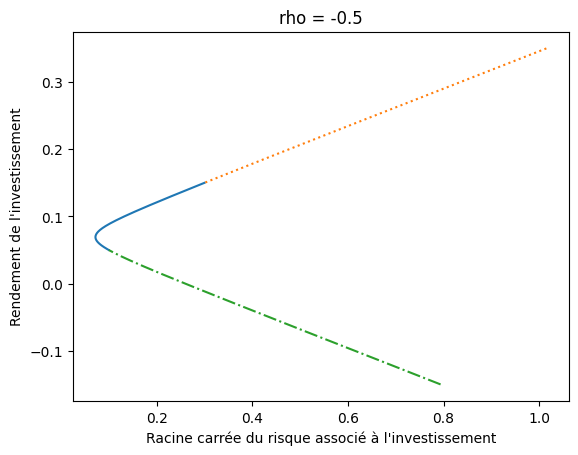

In [48]:
rho = -0.5
sigma = np.array([[sig1**2, rho*sig1*sig2, 0], [rho*sig1*sig2, sig2**2, 0], [0, 0, sig3**2]])

X3_1 = np.empty(1000)
Y3_1 = np.empty(1000)
for i in range(1000):
    x_1 = i/1000
    x_2 = 1 - x_1
    x_3 = 0
    x = np.array([x_1, x_2, x_3])
    X3_1[i] = np.sqrt(np.dot(np.dot(x,sigma),x))
    Y3_1[i] = np.dot(p,x)
    
X3_2 = np.empty(2000)
Y3_2 = np.empty(2000)
for i in range(-2000,0):
    x_1 = i/1000
    x_2 = 1 - x_1
    x_3 = 0
    x = np.array([x_1, x_2, x_3])
    X3_2[i] = np.sqrt(np.dot(np.dot(x,sigma),x))
    Y3_2[i] = np.dot(p,x)

X3_3 = np.empty(2000)
Y3_3 = np.empty(2000)
for i in range(-2000,0):
    x_2 = i/1000
    x_1 = 1 - x_2
    x_3 = 0
    x = np.array([x_1, x_2, x_3])
    X3_3[i] = np.sqrt(np.dot(np.dot(x,sigma),x))
    Y3_3[i] = np.dot(p,x)

plt.plot(X3_1, Y3_1, '-', label = '')
plt.plot(X3_2, Y3_2, ':', label = '')
plt.plot(X3_3, Y3_3, '-.', label = '')
plt.xlabel("Racine carrée du risque associé à l'investissement")
plt.ylabel("Rendement de l'investissement")
plt.title('rho = -0.5')
plt.show()

On trace maintenant les trois diagrammes sur le même graphe pour mieux observer l'effet de $\rho$.

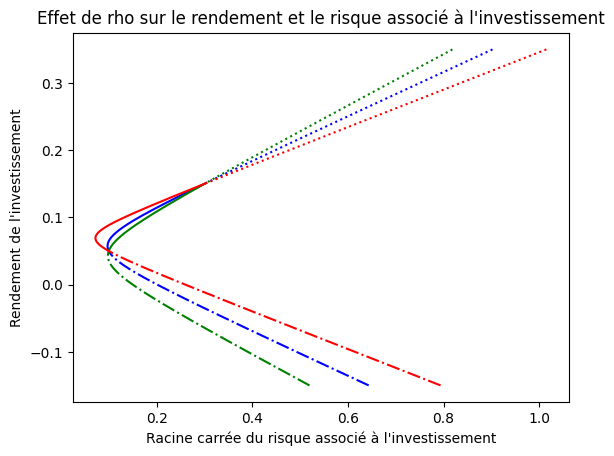

In [49]:
plt.plot(X1_1, Y1_1, '-', color = 'b', label = '')
plt.plot(X1_2, Y1_2, ':', color = 'b', label = '')
plt.plot(X1_3, Y1_3, '-.', color = 'b', label = '')

plt.plot(X2_1, Y2_1, '-', color = 'g', label = '')
plt.plot(X2_2, Y2_2, ':', color = 'g', label = '')
plt.plot(X2_3, Y2_3, '-.', color = 'g', label = '')

plt.plot(X3_1, Y3_1, '-', color = 'r', label = '')
plt.plot(X3_2, Y3_2, ':', color = 'r', label = '')
plt.plot(X3_3, Y3_3, '-.', color = 'r', label = '')

plt.xlabel("Racine carrée du risque associé à l'investissement")
plt.ylabel("Rendement de l'investissement")
plt.title("Effet de rho sur le rendement et le risque associé à l'investissement")
plt.show()

La courbe bleue représente $\rho$ = 0.1, la courbe verte représente $\rho$ = 0.5 et la courbe rouge représente $\rho$ = -0.5.

Sur des investissements long-termes ($x_1$ et $x_2$ positifs, courbes en trait plein), on peut observer que, lorsque $\rho$ diminue, les actifs sont alors de moins en moins corrélés, et se compensent alors mieux : on a une diminution du risque pour un même rendement. À l'inverse, quand $\rho$ augmente, les investissements sont plus corrélés et on a donc moins de diversification : le risque global augmente.

Les portefeuilles "short" (avec $x_1$ ou $x_2$ négatif, courbes en tirets et en pointillés) peuvent permettre des combinaisons plus efficaces s'ils sont bien gérés, mais au prix de risques plus élevés.

$(c)$

On ne résout qu'avec la méthode SLSQP de Scipy à présent pour plus de clarté, on n'utilise plus Casadi mais la réponse reste la même.

In [50]:
# rho = 0.5

rho1 = 0.5
sigma1 = np.array([[sig1**2, rho1*sig1*sig2, 0], [rho1*sig1*sig2, sig2**2, 0], [0, 0, sig3**2]])

def var1(x):
    return x.T @ sigma1 @ x

print('méthode SLSQP avec Scipy (rho = 0.5)')
start_time = time.time()
res = optimize.minimize(var1, x0, method='SLSQP', jac=None, constraints=contraintes, options={'disp': True})
print("Allocation :", res.x)
print("Durée : ", time.time()-start_time)

méthode SLSQP avec Scipy (rho = 0.5)
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.02112359551317994
            Iterations: 4
            Function evaluations: 16
            Gradient evaluations: 4
Allocation : [0.65168539 0.24719102 0.10112359]
Durée :  0.003290891647338867


In [51]:
# rho = -0.5

rho2 = -0.5
sigma2 = np.array([[sig1**2, rho2*sig1*sig2, 0], [rho2*sig1*sig2, sig2**2, 0], [0, 0, sig3**2]])

def var2(x):
    return x.T @ sigma2 @ x

print('méthode SLSQP avec Scipy (rho = -0.5)')
start_time = time.time()
res = optimize.minimize(var2, x0, method='SLSQP', jac=None, constraints=contraintes, options={'disp': True})
print("Allocation :", res.x)
print("Durée : ", time.time()-start_time)

méthode SLSQP avec Scipy (rho = -0.5)
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.010392523359564722
            Iterations: 4
            Function evaluations: 16
            Gradient evaluations: 4
Allocation : [0.60934579 0.31775701 0.07289719]
Durée :  0.0032739639282226562


Comme prévu dans l'analyse de la question précédente, la valeur de la variance (et donc du risque associé à l'investissement) est plus élevé dans le cas où $\rho = 0.5$ que dans le cas où $\rho = -0.5$. En effet, les investissements étant plus corrélés, il y a moins de diversification et donc plus de risques pris par l'investisseur.

# Question 8

$(a)$

In [52]:
# pour r = 0.2

r1 = 0.2

contraintes1 = ({'type': 'eq', 'fun': lambda x:  unit.T@x -1},
        {'type': 'eq', 'fun': lambda x: p.T@x - r1})

print('  Méthode SLSQP avec Scipy (r = 0.2)')
start_time = time.time()
res = optimize.minimize(var, x0, method='SLSQP', jac=None, constraints=contraintes1, options={'disp': True})
print("Allocation :", res.x)
print("Durée : ", time.time()-start_time)

  Méthode SLSQP avec Scipy (r = 0.2)
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.10936448578499276
            Iterations: 4
            Function evaluations: 16
            Gradient evaluations: 4
Allocation : [-0.05420561  0.75700935  0.29719626]
Durée :  0.0019462108612060547


L'optimum passe par une position courte sur l'actif 1 !

In [53]:
# pour r = 0.15

r2 = 0.15

contraintes2 = ({'type': 'eq', 'fun': lambda x:  unit.T@x -1},
        {'type': 'eq', 'fun': lambda x: p.T@x - r2})

print('  Méthode SLSQP avec Scipy (r = 0.15)')
start_time = time.time()
res = optimize.minimize(var, x0, method='SLSQP', jac=None, constraints=contraintes2, options={'disp': True})
print("Allocation :", res.x)
print("Durée : ", time.time()-start_time)

  Méthode SLSQP avec Scipy (r = 0.15)
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.04420093447428376
            Iterations: 4
            Function evaluations: 16
            Gradient evaluations: 4
Allocation : [0.27757009 0.53738318 0.18504673]
Durée :  0.0021147727966308594


In [54]:
'''
# équivalent avec Casadi pour r = 0.2

opti_cons1 = casadi.Opti();
x1 = opti_cons1.variable(3)

opti_cons1.minimize(var(x1))
opti_cons1.subject_to(dot(unit.T, x1) - 1 == 0)
opti_cons1.subject_to(dot(p.T, x1) - r1 == 0)

opti_cons1.set_initial(x1,x0)
opti_cons1.solver('ipopt')

print("\n \n  Résolution avec Casadi")
start_time = time.time()
sol = opti_cons1.solve()
print("Durée : ", time.time()-start_time)
print(sol.value(x1))
'''

'\n# équivalent avec Casadi pour r = 0.2\n\nopti_cons1 = casadi.Opti();\nx1 = opti_cons1.variable(3)\n\nopti_cons1.minimize(var(x1))\nopti_cons1.subject_to(dot(unit.T, x1) - 1 == 0)\nopti_cons1.subject_to(dot(p.T, x1) - r1 == 0)\n\nopti_cons1.set_initial(x1,x0)\nopti_cons1.solver(\'ipopt\')\n\nprint("\n \n  Résolution avec Casadi")\nstart_time = time.time()\nsol = opti_cons1.solve()\nprint("Durée : ", time.time()-start_time)\nprint(sol.value(x1))\n'

In [55]:
'''
# équivalent avec Casadi pour r = 0.15

opti_cons2 = casadi.Opti();
x2 = opti_cons2.variable(3)

opti_cons2.minimize(var(x2))
opti_cons2.subject_to(dot(unit.T, x2) - 1 == 0)
opti_cons2.subject_to(dot(p.T, x2) - r2 == 0)

opti_cons2.set_initial(x2,x0)
opti_cons2.solver('ipopt')

print("\n \n  Résolution avec Casadi")
start_time = time.time()
sol = opti_cons2.solve()
print("Durée : ", time.time()-start_time)
print(sol.value(x2))
'''

'\n# équivalent avec Casadi pour r = 0.15\n\nopti_cons2 = casadi.Opti();\nx2 = opti_cons2.variable(3)\n\nopti_cons2.minimize(var(x2))\nopti_cons2.subject_to(dot(unit.T, x2) - 1 == 0)\nopti_cons2.subject_to(dot(p.T, x2) - r2 == 0)\n\nopti_cons2.set_initial(x2,x0)\nopti_cons2.solver(\'ipopt\')\n\nprint("\n \n  Résolution avec Casadi")\nstart_time = time.time()\nsol = opti_cons2.solve()\nprint("Durée : ", time.time()-start_time)\nprint(sol.value(x2))\n'

Notons tout d'abord qu'un actif $i$ est d'autant plus risqué que $\sigma_i$ est élevé. Ici on a $\sigma_{1} = 10 \% < \sigma_{2} = 30 \% < \sigma_{3} = 80 \%$.

Le rendement d'un actif est quant à lui lié à $\overline{p}$ : on a $\overline{p}_1 = 5 \% < \overline{p}_2 = 15 \% < \overline{p}_3 = 30 \%$, donc les rendements sont croissants avec le numéro de l'actif.

Pour $r = 0,1$, qui est un rendement relativement faible, la solution optimale privilégie l'actif 1, qui est le moins risqué. Le risque du portefeuille est alors relativement faible (justifié par le faible rendement de l'investissement).

Pour $r = 0,2$, plus élevé, le risque minimal augmente considérablement ; on voit apparaître une position courte sur l'actif 1, et les allocations sur les actifs 2 et 3 (plus risqués mais avec un rendement moyen plus élevé) augmentent.

Pour $r = 0,15$ entre les deux, le risque et l'allocation sont intermédiaires. L'allocation est davantage répartie entre les actifs, avec notamment davantage d'investissement dans l'actif 2, et il n'y a pas de position courte.

Ces résultats illustrent un compromis d'apparence fondamentale en finance : pour obtenir un rendement cible plus élevé, l'investisseur doit souvent accepter un niveau de risque plus élevé.

De plus, on voit que le profil d'allocation change beaucoup en fonction du rendement cible ; pour obtenir des rendements cibles élevés, on s'en remet donc à utiliser des positions courtes, que l'on paye en augmentation du risque global.

$(b)$

Nous avons vu que la solution optimale pour $r = 0,15$ est intermédiaire en termes de risque et d'allocation entre les solutions pour $r = 0,1$ et $r = 0,2$. On peut donc intuiter à première vue qu'un portefeuille optimal pour un rendement entre $r = 0,1$ et $r = 0,2$ peut s'obtenir en pondérant les portefeuilles optimaux pour ces deux situations.

__Justification du _Two-Fund Theorem_ :__

La frontière efficiente, telle que présentée dans l'énoncé, représente les allocations qui engendrent le plus grand retour sur investissement (à un niveau de risque donné). Les investisseurs ont donc intérêt à établir leurs allocations sur cette frontière.

De plus, comme les allocations sont ici des vecteurs, connaissant les allocations de deux acteurs A et B, d'après les résultats précédents, un investisseur C peut créer son allocation en effectuant une combinaison linéaire des allocations de A et de B.

$(c)$

Résolvons analytiquement le problème $(4)$ : pour ce faire, on va utiliser la méthode du Lagrangien, qui repose sur le fait que tout point stationnaire de $f$ est un point stationnaire du lagrangien pour un certain multiplicateur de Lagrange.

On définit le lagrangien comme suit :
$$\mathcal{L}(z, \lambda) =  f(z) + \lambda^T c_{eq}(z)$$
avec $\lambda = \begin{pmatrix} \lambda_{1} \\ \lambda_{2} \end{pmatrix}$ le vecteur des multiplicateurs de Lagrange associés aux contraintes de budget et de rendement.

On peut réécrire le lagrangien comme fonction de $x, \lambda_{1}, \lambda_{2}$ :
$$\mathcal{L}(x, \lambda_{1}, \lambda_{2}) = x^T \Sigma x + \lambda_{1} (\bold{1}^T x - 1) + \lambda_{2} (\overline{p}^T x - r)$$

La solution optimale est point stationnaire du lagrangien, d'où :
$$\begin{cases}
\frac{\partial \mathcal{L}}{\partial x} = 2 \Sigma x + \lambda_{1} \bold{1} + \lambda_{2} \overline{p} = 0 & (1)
\\
\frac{\partial \mathcal{L}}{\partial \lambda_{1}} = \bold{1}^T x - 1 = 0 & (2)
\\
\frac{\partial \mathcal{L}}{\partial \lambda_{2}} = \overline{p}^T x - r = 0 & (3)
\end{cases}$$

De $(1)$ on déduit $x$ en fonction de $\lambda_{1}$ et $\lambda_{2}$ :
$$ x = -2 \Sigma^{-1} [\lambda_{1} \bold{1} + \lambda_{2} \overline{p}]$$

On réinjecte dans $(2)$ et $(3)$ :
$$\begin{cases}
\frac{1}{2} \big ( \lambda_{1} \bold{1}^T \Sigma^{-1} \bold{1} + \lambda_{2} \bold{1}^T \Sigma^{-1} \overline{p} \big ) = -1
\\
\frac{1}{2} \big ( \lambda_{1} \overline{p}^T \Sigma^{-1} \bold{1} + \lambda_{2} \overline{p}^T \Sigma^{-1} \overline{p} \big ) = -r
\end{cases}$$

Pour simplifier les notations, on pose :
$$A = \bold{1}^T \Sigma^{-1} \bold{1} \; ; \; B = \bold{1}^T \Sigma^{-1} \overline{p} = \overline{p}^T \Sigma^{-1} \bold{1} \; ; \; C = \overline{p}^T \Sigma^{-1} \overline{p}$$

Notons que $A$, $B$ et $C$ ne dépendent pas de $r$ mais seulement des paramètres de marché.

On a alors un système de deux équations à deux inconnues ($\lambda_{1}$ et $\lambda_{2}$), qu'on résout :
$$\begin{cases}
\lambda_{1} A + \lambda_{2} B = -2
\\
\lambda_{1} B + \lambda_{2} C = -2r
\end{cases}
\iff
\begin{cases}
\lambda_{1} = -2 \frac{rB - C}{B^2 - AC}
\\
\lambda_{2} = 2 \frac{rA - B}{B^2 - AC}
\end{cases}$$

qui existent _ssi_ $B^2 ≠ AC$, condition que l'on va considérer comme remplie.

En réinjectant, on obtient alors une expression explicite de $x^*$, qu'on peut regrouper de la sorte :
$$x^* = A' + B' r$$
avec $A'$, $B'$ dépendant des paramètres de marché mais pas de $r$.

Ainsi, tout portefeuille efficient $x^*(r)$ peut être exprimé comme combinaison linéaire de deux portefeuilles, représentés par les vecteurs $A$ et $B$ et ne dépendant pas de $r$ ; on obtient donc un ensemble de portefeuilles efficients avec 2 portefeuilles de base, ce qui achève la preuve.

# Question 9

In [56]:
r9 = 0.4
s_M = 0.5
x0 = np.array([0., 0., 0.])

# Comme x et s sont liées, on va créer un array 'variables' de taille 6 qui contient la concaténation de x et de s
def var2(variables):
    x = variables[:3]
    return x.T @ sigma @ x

# ATTENTION : les contraintes inégalités sont traitées dans "l'autre sens" par scipy.optimize.minimize
def contrainte_sx(variables):
    x = variables[:3]
    s = variables[3:]
    return s + x #on veut la contrainte inégalité s >= -x

def contrainte_spos(variables):
    s = variables[3:]
    return s

def contrainte_sM(variables):
    s = variables[3:]
    return s_M - unit.T@s

contraintes9 = ({'type': 'eq', 'fun': lambda variables:  unit.T@variables[:3] -1},
        {'type': 'eq', 'fun': lambda variables: p.T@variables[:3] - r9},
        {'type': 'ineq', 'fun': contrainte_sx},
        {'type': 'ineq', 'fun': contrainte_spos},
        {'type': 'ineq', 'fun': contrainte_sM})

variables0 = np.concatenate((x0, np.zeros(3)), axis=0) #initialisation de x et s
bounds_x = [(None, None)] * 3 #pas d'encadrement de x
bounds_s = [(0, None)]*3 #pour s'assurer que s >= 0
bounds = bounds_x + bounds_s

print('  Méthode SLSQP avec Scipy (r = 0.4, s_M = 0.5)')
start_time = time.time()
res = optimize.minimize(var2, variables0, method='SLSQP', jac=None, bounds=bounds, constraints=contraintes9, options={'disp': True})
print("Allocation :", res.x[:3]) #on n'affiche que x, pas s
print("Durée : ", time.time()-start_time)

  Méthode SLSQP avec Scipy (r = 0.4, s_M = 0.5)
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.1452777788021595
            Iterations: 3
            Function evaluations: 21
            Gradient evaluations: 3
Allocation : [-0.5         0.16666667  1.33333333]
Durée :  0.002106904983520508


In [57]:
# Comparaison avec l'algorithme précédent sans les contraintes inégalité
r3 = 0.4

contraintes3 = ({'type': 'eq', 'fun': lambda x:  unit.T@x -1},
        {'type': 'eq', 'fun': lambda x: p.T@x - r3})

print('  Méthode SLSQP avec Scipy (r = 0.4)')
start_time = time.time()
res = optimize.minimize(var, x0, method='SLSQP', jac=None, constraints=contraintes3, options={'disp': True})
print("Allocation :", res.x)
print("Durée : ", time.time()-start_time)

  Méthode SLSQP avec Scipy (r = 0.4)
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.6835700869216406
            Iterations: 4
            Function evaluations: 16
            Gradient evaluations: 4
Allocation : [-1.3813085   1.63551417  0.74579433]
Durée :  0.0022420883178710938


Le risque minimal est beaucoup plus élevé que celui sans limitation des positions courtes. Les positions courtes offrent en effet une flexibilité pour les investisseurs de parier _contre_ certains actifs, ce qui peut réduire le risque global dans certaines situations. Par essence, ajouter une contrainte réduit l'ensemble de recherche des solutions, et donc peut potentiellement ne plus inclure le minimum global de la fonction.

En revanche, les investissements sont moins extrêmes : en effet, en limitant les positions courtes, on limite aussi la diversification des allocations et l'écart d'investissement entre les actifs (on ne peut pas compenser les pertes potentielles sur une allocation avec des positions short pour un autre actif).

On remarque enfin que la contrainte sur la position courte est **active** dans la résolution de cette question, puisque la position courte sur l'actif 1 est réduite à $-0,5$, ce qui est la limite imposée par $s_M$. Ainsi la contrainte a bien eu un effet direct sur la solution.

En conclusion, la limitation des positions courtes augmente le risque minimal du portefeuille puisqu'il restreint l'espace des solutions ; cette restriction modifie donc l'allocation optimale des actifs.

# Question 10

Le coût présenté dans l'équation (7) représente la différence entre le risque associé à l'investissement $x$ (modulé d'une constante $\mu$) et le rendement $r$ donné. On cherche à minimiser ce coût, c'est-à-dire à réduire la différence entre le risque et le rendement et donc à obtenir le meilleur rendement pour un risque minimum pris.

$-\bar{p}^Tx$ représente l'opposé du rendement $r$. Si $-\bar{p}^Tx$ est positif, alors cela signifie que le rendement $r$ est négatif. Au contraire, si $-\bar{p}^Tx$ est négatif, alors cela signifie que le rendement $r$ est positif.

Dans le cas où $\mu$ = 0, le problème d'optimisation se réduit à maximiser le rendement. En effet, résoudre le problème de minimisation $\min -\bar{p}^Tx$ est équivalent à résoudre le problème de maximisation $\max \bar{p}^Tx$.

# Question 11

Le cas $\mu$ = 0 correspond à la situation où le risque associé à l'investissement $x$ est nul. Si tous les $x_i$ sont positifs, alors il faut alors concentrer l'ensemble de l'investissement $x$ sur la variation du prix des actifs sur le long terme $\bar{p}_i$ le plus élevé. Dans le cas de la question 6 (avec $p_1$ = 5%, $p_2$ = 15% et $p_3$ = 30%), on s'attendrait à obtenir :
$x$ = 
$\begin{pmatrix}
0 \\
0 \\
x
\end{pmatrix}$

Le cas $\mu = +\infty$ correspond à la situation où l'investisseur accorde une importance bien plus grande à la minimisation du risque qu'à obtenir un bon rendement. On s'attend alors ici que le risque pris soit minimal, et donc que l'investissement soit concentré plus particulièrement sur la variation du prix $p$ la plus faible. On s'attendrait alors à obtenir : 

In [59]:
# définition de la nouvelle fonction coût

mu = 1 #juste pour initialiser mu > 0

def cost(x):
    return -p.T @ x + mu*x.T @ sigma @ x

contrainte11 = ({'type': 'eq', 'fun': lambda x:  unit.T@x -1})

In [60]:
mu = 0

print('méthode SLSQP avec Scipy (mu = 0)')
start_time = time.time()
res = optimize.minimize(cost, x0, method='SLSQP', jac=None, constraints=contrainte11, options={'disp': True})
print("Allocation :", res.x)
print("Durée : ", time.time()-start_time)

méthode SLSQP avec Scipy (mu = 0)
Rank-deficient equality constraint subproblem HFTI    (Exit mode 7)
            Current function value: -80467189009407.11
            Iterations: 44
            Function evaluations: 206
            Gradient evaluations: 44
Allocation : [-3.24520095e+14  4.41889750e+12  3.20101197e+14]
Durée :  0.016126155853271484


L'algorithme a du mal à résoudre le problème car la contrainte de budget seule rend le système redondant (d'où le problème de rang). On pourrait améliorer la situation en renseignant une tolérance avec l'argument $\texttt{tol}$.

In [61]:
mu = 10e10 #mu tend vers l'infini

print('méthode SLSQP avec Scipy (mu = 0)')
start_time = time.time()
res = optimize.minimize(cost, x0, method='SLSQP', jac=None, constraints=contrainte11, options={'disp': True})
print("Allocation :", res.x)
print("Durée : ", time.time()-start_time)

méthode SLSQP avec Scipy (mu = 0)
Optimization terminated successfully    (Exit mode 0)
            Current function value: 515052160.8827161
            Iterations: 5
            Function evaluations: 48
            Gradient evaluations: 5
Allocation : [0.80119226 0.19076006 0.00804768]
Durée :  0.0031909942626953125


Les résultats de la simulation confirment notre prédiction de comportement. Le cas $\mu \to +\infty$ signifie qu'on accorde une importance _infiniment plus grande_ à la minimisation du risque qu'à la maximisation du rendement. L'investisseur cherchera donc l'allocation qui a la variance la plus faible, en accordant une importance négligeable au rendement de cette allocation. Il privilégie donc les actifs les moins risqués, même s'ils impliquent un plus faible rendement : on obtient donc un placement majoritaire sur $x_1$, comme le montre la simulation.